# Station–ERA5 Diagnostics

Team: Codellera Andina  
Authors:  
- María Fernanda Molina  
- Nataly Sarmiento  
- Isabela Saud

##  Diagnostics for Southern Italy AOI

This part of te script builds a daily comparison dataset between ECA&D weather stations and ERA5-Land Tmax for all stations located inside a predefined Area of Interest (AOI) over southern Italy (2020–2023). It:
- Loads the AOI polygon (GeoPackage), the full ECA&D station metadata (stations.txt), and filters all stations that fall inside the AOI.
- Converts station coordinates from DMS to decimal degrees and saves the subset of stations inside the AOI as a GeoPackage for use in QGIS.
- Loads ERA5-Land daily maximum 2 m temperature (t2m) from the derived NetCDF files, converts it to °C, and extracts the nearest ERA5 grid cell time series for each station.
- Reads all ECAD station TX files (TX_STAID*.txt), keeps only good-quality records (Q_TX = 0), and builds a daily TX time series per station for 2020–2023.
- Merges station TX and ERA5 Tmax at daily resolution, computes the error error = T_ERA5 – T_station, and exports the full daily table for all stations.
- Aggregates the daily data by station to compute diagnostics such as total coverage, number of “good” summers, bias, RMSE, and correlation (overall and for JJA), and flags stations that meet the quality criteria.
- Saves two main outputs:
A daily table with station TX, ERA5 Tmax, and error for all stations in the AOI.
A station-level diagnostics table summarizing data quality and ERA5 performance, to support the selection of the final 10–15 stations for the hackathon analysis.


In [2]:
from pathlib import Path
from glob import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from shapely.geometry import Point

# ---------- 1. CONFIG – paths and basic settings (match your existing notebook) ---------

DATA_DIR     = Path(r"D:\Polimi\GenHack 2025\Data")
STATIONS_DIR = DATA_DIR / "ECA_blend_tx"                       # ECAD TX station files
ERA5_DIR     = DATA_DIR / "derived-era5-land-daily-statistics" # ERA5-Land daily Tmax

# Area of Interest for southern Italy (saved as GeoPackage from QGIS)
PATH_AOI     = DATA_DIR / "south_italy_aoi.gpkg"

# ECAD station metadata file (stations.txt from ECA&D)
PATH_ST_META = STATIONS_DIR / "stations.txt"

# Output folder for diagnostics and daily tables
OUT_DIR = DATA_DIR / "outputs"
OUT_DIR.mkdir(exist_ok=True)

# Output files
OUT_DAILY_TABLE = OUT_DIR / "stations_daily_with_error.parquet"
OUT_DIAG_TABLE  = OUT_DIR / "station_diagnostics.csv"

# Time window and definition of summer (JJA)
YEARS_TARGET   = [2020, 2021, 2022, 2023]
SUMMER_MONTHS  = [6, 7, 8]  # JJA


# ----------- 2. HELPERS (ported from the original notebook) -----------


def dms_to_dd_ecad(s):
    """
    Convert DMS string from ECA&D ('+38:11:00', '-05:30:00', etc.) to decimal degrees.
    """
    if pd.isna(s):
        return np.nan
    s = str(s).strip()
    if not s:
        return np.nan

    # Extract sign and strip leading +/-
    sign = -1 if s[0] == "-" else 1
    if s[0] in "+-":
        s = s[1:]

    parts = s.split(":")
    if len(parts) != 3:
        return np.nan

    d, m, sec = map(float, parts)
    return sign * (d + m / 60.0 + sec / 3600.0)


def load_era5_tmax_celsius():
    """
    Load ERA5-Land daily maximum 2 m temperature (t2m) from the derived
    NetCDF files and return it in °C, together with the names of
    latitude, longitude and time coordinates.
    """
    variable2statistic = {"2m_temperature": "daily_maximum"}
    variable2datavar   = {"2m_temperature": "t2m"}

    variable  = "2m_temperature"
    statistic = variable2statistic[variable]
    datavar   = variable2datavar[variable]

    # Pattern used in the derived ERA5 files
    pattern = str(ERA5_DIR / f"*_{variable}_{statistic}.nc")
    filepaths = sorted(glob(pattern))
    if not filepaths:
        raise FileNotFoundError(f"No ERA5 files found matching {pattern}")

    print(f"\nLoading ERA5 files ({len(filepaths)}):")
    for fp in filepaths:
        print("  ", fp)

    # Combine all years along the coordinates
    ds = xr.open_mfdataset(filepaths, combine="by_coords")

    # Detect coordinate names (latitude / longitude may vary)
    if "latitude" in ds.coords:
        lat_name = "latitude"
    elif "lat" in ds.coords:
        lat_name = "lat"
    else:
        raise KeyError("Could not find latitude coordinate in ERA5 dataset")

    if "longitude" in ds.coords:
        lon_name = "longitude"
    elif "lon" in ds.coords:
        lon_name = "lon"
    else:
        raise KeyError("Could not find longitude coordinate in ERA5 dataset")

    # Time coordinate can be "time" or "valid_time"
    if "time" in ds.coords:
        time_name = "time"
    elif "valid_time" in ds.coords:
        time_name = "valid_time"
    else:
        raise KeyError("Could not find time coordinate in ERA5 dataset")

    da_kelvin = ds[datavar]
    da_celsius = da_kelvin - 273.15  # convert K → °C
    da_celsius.attrs["units"] = "degC"

    return da_celsius, lat_name, lon_name, time_name


def era5_series_for_point(ds_var, lat_name, lon_name, time_name, lon, lat):
    """
    Extract the ERA5 time series at the grid cell closest to (lon, lat).
    Returns a DataFrame with columns: [date, tmax_era5].
    """
    da = ds_var.sel({lat_name: lat, lon_name: lon}, method="nearest")
    df = da.to_dataframe(name="tmax_era5").reset_index()
    df = df.rename(columns={time_name: "date"})
    return df[["date", "tmax_era5"]]


def summer_mask(dates):
    """Return a boolean mask for summer days (JJA)."""
    return dates.dt.month.isin(SUMMER_MONTHS)


# -------- 3. LOAD AOI AND STATION METADATA (ECA&D)  ----------


# Load the Area of Interest for southern Italy and reproject to WGS84
aoi = gpd.read_file(PATH_AOI).to_crs("EPSG:4326")
print("AOI loaded, bounds:", aoi.total_bounds)

# Find header line with "STAID" in stations.txt (skip metadata comments)
header_line_idx = None
with open(PATH_ST_META, "r", encoding="latin1") as f:
    for i, line in enumerate(f):
        if line.startswith("STAID"):
            header_line_idx = i
            print("Found ECAD header at line:", i)
            break

if header_line_idx is None:
    raise RuntimeError("Could not find header starting with 'STAID' in stations.txt")

# Read ECAD station metadata from that header line onwards
stations_meta_raw = pd.read_csv(
    PATH_ST_META,
    skiprows=header_line_idx,
    sep=",",
    engine="python",
)
stations_meta_raw.columns = [c.strip() for c in stations_meta_raw.columns]

stations_meta = stations_meta_raw.copy()
stations_meta["STAID"]   = stations_meta["STAID"].astype(int)
stations_meta["STANAME"] = stations_meta["STANAME"].str.strip()
stations_meta["CN"]      = stations_meta["CN"].str.strip()

# Convert latitude/longitude from DMS to decimal degrees
stations_meta["LAT_dd"] = stations_meta["LAT"].apply(dms_to_dd_ecad)
stations_meta["LON_dd"] = stations_meta["LON"].apply(dms_to_dd_ecad)

print("\nStation metadata sample:")
print(stations_meta[["STAID", "STANAME", "CN", "LAT_dd", "LON_dd"]].head())

# Build a GeoDataFrame with station locations
gdf_st = gpd.GeoDataFrame(
    stations_meta,
    geometry=[Point(xy) for xy in zip(stations_meta["LON_dd"], stations_meta["LAT_dd"])],
    crs="EPSG:4326",
)

# Spatial join to keep only stations within the AOI
gdf_st_roi = gpd.sjoin(gdf_st, aoi, predicate="within")
stations_roi = gdf_st_roi[["STAID", "STANAME", "LAT_dd", "LON_dd", "geometry"]].copy()
stations_roi = stations_roi.rename(
    columns={"STAID": "station_id", "STANAME": "name", "LAT_dd": "lat", "LON_dd": "lon"}
)

print(f"\nTotal ECAD stations: {len(gdf_st)}")
print(f"Stations in AOI:     {len(stations_roi)}")

# Save all stations inside the AOI as GeoPackage (for inspection in QGIS)
STATIONS_AOI_GPKG = OUT_DIR / "stations_in_south_italy_aoi.gpkg"
stations_roi.to_file(STATIONS_AOI_GPKG, driver="GPKG")
print("Saved stations in AOI to:", STATIONS_AOI_GPKG)


# ---------- 4. LOAD ERA5 DAILY TMAX (°C) ----------------


tmax_era5_c, lat_name, lon_name, time_name = load_era5_tmax_celsius()
print("\nERA5 DataArray:", tmax_era5_c)

# Restrict ERA5 to the target period (2020–2023)
tmax_era5_c = tmax_era5_c.sel(
    {time_name: slice("2020-01-01", "2023-12-31")}
)



# -------------- 5. BUILD DAILY STATION TX TABLE FOR ALL STATIONS IN AOI ----------------


all_station_tx = []

for _, row in stations_roi.iterrows():
    sid = int(row["station_id"])
    sta_name = row["name"]

    path = STATIONS_DIR / f"TX_STAID{sid:06d}.txt"
    if not path.exists():
        print(f"WARNING: file missing for station {sid}: {path}")
        continue

    # Read the raw ECAD file for this station
    df_raw = pd.read_csv(
        path,
        skiprows=20,
        skipinitialspace=True,
    )

    # Keep only good-quality records (Q_TX = 0)
    df_good = df_raw[df_raw["Q_TX"] == 0].copy()
    if df_good.empty:
        continue

    # Convert date and temperature units
    df_good["date"] = pd.to_datetime(df_good["DATE"], format="%Y%m%d")
    df_good["tx"]   = df_good["TX"] / 10.0  # 0.1°C → °C
    df_good = df_good[["date", "tx"]]

    # Attach station metadata
    df_good["station_id"] = sid
    df_good["name"]       = sta_name
    df_good["lon"]        = row["lon"]
    df_good["lat"]        = row["lat"]

    # Restrict to the target years
    df_good = df_good[df_good["date"].dt.year.isin(YEARS_TARGET)]

    all_station_tx.append(df_good)

if not all_station_tx:
    raise RuntimeError("No valid station TX data found in AOI.")

df_tx = pd.concat(all_station_tx, ignore_index=True)
print("\nStation TX daily table shape:", df_tx.shape)


#  -------------- 6. BUILD DAILY TABLE WITH ERA5 + ERROR---------------


daily_list = []

for sid, df_s in df_tx.groupby("station_id"):
    # Get station metadata
    row_meta = stations_roi[stations_roi["station_id"] == sid].iloc[0]
    lon = row_meta["lon"]
    lat = row_meta["lat"]
    name = row_meta["name"]

    # Extract ERA5 series at the nearest grid cell
    df_era = era5_series_for_point(
        tmax_era5_c,
        lat_name,
        lon_name,
        time_name,
        lon=lon,
        lat=lat,
    )

    # Merge station TX and ERA5 Tmax on common dates
    df_merge = pd.merge(df_s, df_era, on="date", how="inner")
    if df_merge.empty:
        continue

    # Compute error (ERA5 - station) and keep coordinates
    df_merge["error"] = df_merge["tmax_era5"] - df_merge["tx"]
    df_merge["lon"]   = lon
    df_merge["lat"]   = lat
    df_merge["name"]  = name

    daily_list.append(df_merge)

df_daily = pd.concat(daily_list, ignore_index=True)
df_daily.to_parquet(OUT_DAILY_TABLE, index=False)

print("\nDaily merged table shape:", df_daily.shape)


# ------------------- 7. STATION DIAGNOSTICS ----------------------------


def station_diag(df):
    """
    Compute coverage and skill metrics for a single station,
    using the merged daily table (TX + ERA5 + error).
    """
    out = {}
    out["station_id"] = df["station_id"].iloc[0]
    out["name"]       = df["name"].iloc[0]
    out["lon"]        = df["lon"].iloc[0]
    out["lat"]        = df["lat"].iloc[0]

    df = df.copy()
    df["is_valid"]  = df["tx"].notna() & df["tmax_era5"].notna()
    df["year"]      = df["date"].dt.year
    df["is_summer"] = summer_mask(df["date"])

    # Overall coverage (all days 2020–2023)
    out["coverage_total"] = df["is_valid"].mean()

    # Number of summers (JJA) with ≥ 80% valid days
    good_summers = 0
    for y in YEARS_TARGET:
        df_y = df[(df["year"] == y) & df["is_summer"]]
        if len(df_y) == 0:
            continue
        cov_y = df_y["is_valid"].mean()
        if cov_y >= 0.8:
            good_summers += 1
    out["good_summers"] = good_summers

    # Skill metrics (all valid days)
    df_valid = df[df["is_valid"]]
    if len(df_valid) > 10:
        err = df_valid["error"]
        out["bias"] = err.mean()
        out["rmse"] = np.sqrt((err**2).mean())
        out["corr"] = df_valid["tx"].corr(df_valid["tmax_era5"])
    else:
        out["bias"] = np.nan
        out["rmse"] = np.nan
        out["corr"] = np.nan

    # Skill metrics restricted to summer (JJA)
    df_su = df_valid[df_valid["is_summer"]]
    if len(df_su) > 10:
        err_s = df_su["error"]
        out["bias_summer"] = err_s.mean()
        out["rmse_summer"] = np.sqrt((err_s**2).mean())
        out["corr_summer"] = df_su["tx"].corr(df_su["tmax_era5"])
    else:
        out["bias_summer"] = np.nan
        out["rmse_summer"] = np.nan
        out["corr_summer"] = np.nan

    # Final quality flag: station considered "valid" if it has
    # at least two good summers (JJA with coverage >= 80%).
    out["is_valid_station"] = (out["good_summers"] >= 2)

    return out


diag_list = []
for sid, df_st in df_daily.groupby("station_id"):
    diag_list.append(station_diag(df_st))

df_diag = pd.DataFrame(diag_list)
df_diag.to_csv(OUT_DIAG_TABLE, index=False)

print("\nDiagnostics head:")
print(df_diag.head())


AOI loaded, bounds: [12.  36.  19.5 41.5]
Found ECAD header at line: 17

Station metadata sample:
   STAID                STANAME  CN     LAT_dd     LON_dd
0      1                VAEXJOE  SE  56.866667  14.800000
1      2                  FALUN  SE  60.616667  15.616667
2      3               STENSELE  SE  65.066667  17.166389
3      4             LINKOEPING  SE  58.400000  15.533056
4      5  LINKOEPING-MALMSLAETT  SE  58.400000  15.533056

Total ECAD stations: 8568
Stations in AOI:     262
Saved stations in AOI to: D:\Polimi\GenHack 2025\Data\outputs\stations_in_south_italy_aoi.gpkg

Loading ERA5 files (6):
   D:\Polimi\GenHack 2025\Data\derived-era5-land-daily-statistics\2020_2m_temperature_daily_maximum.nc
   D:\Polimi\GenHack 2025\Data\derived-era5-land-daily-statistics\2021_2m_temperature_daily_maximum.nc
   D:\Polimi\GenHack 2025\Data\derived-era5-land-daily-statistics\2022_2m_temperature_daily_maximum.nc
   D:\Polimi\GenHack 2025\Data\derived-era5-land-daily-statistics\2023_2m

In [6]:
# Save valid stations (is_valid_station = True) as a GeoPackage
df_valid = df_diag[df_diag["is_valid_station"]].copy()
gdf_valid = gpd.GeoDataFrame(
    df_valid,
    geometry=gpd.points_from_xy(df_valid["lon"], df_valid["lat"]),
    crs="EPSG:4326",
)
VALID_STATIONS_GPKG = OUT_DIR / "valid_stations_south_italy.gpkg"
gdf_valid.to_file(VALID_STATIONS_GPKG, driver="GPKG")
print("Saved valid stations to:", VALID_STATIONS_GPKG)

Saved valid stations to: D:\Polimi\GenHack 2025\Data\outputs\valid_stations_south_italy.gpkg


### Important Conclusion after this Diagnosis

We initially attempted to analyze the Reggio–Messina region. However, ECAD ground-truth coverage for summer 2020–2023 was extremely limited, with almost no stations providing continuous and good-quality Tmax records. With green you can see the weather stations with good quality data for at least 2 summers between 2020-2023 and with red all the stations that did not fullfilled this condition.
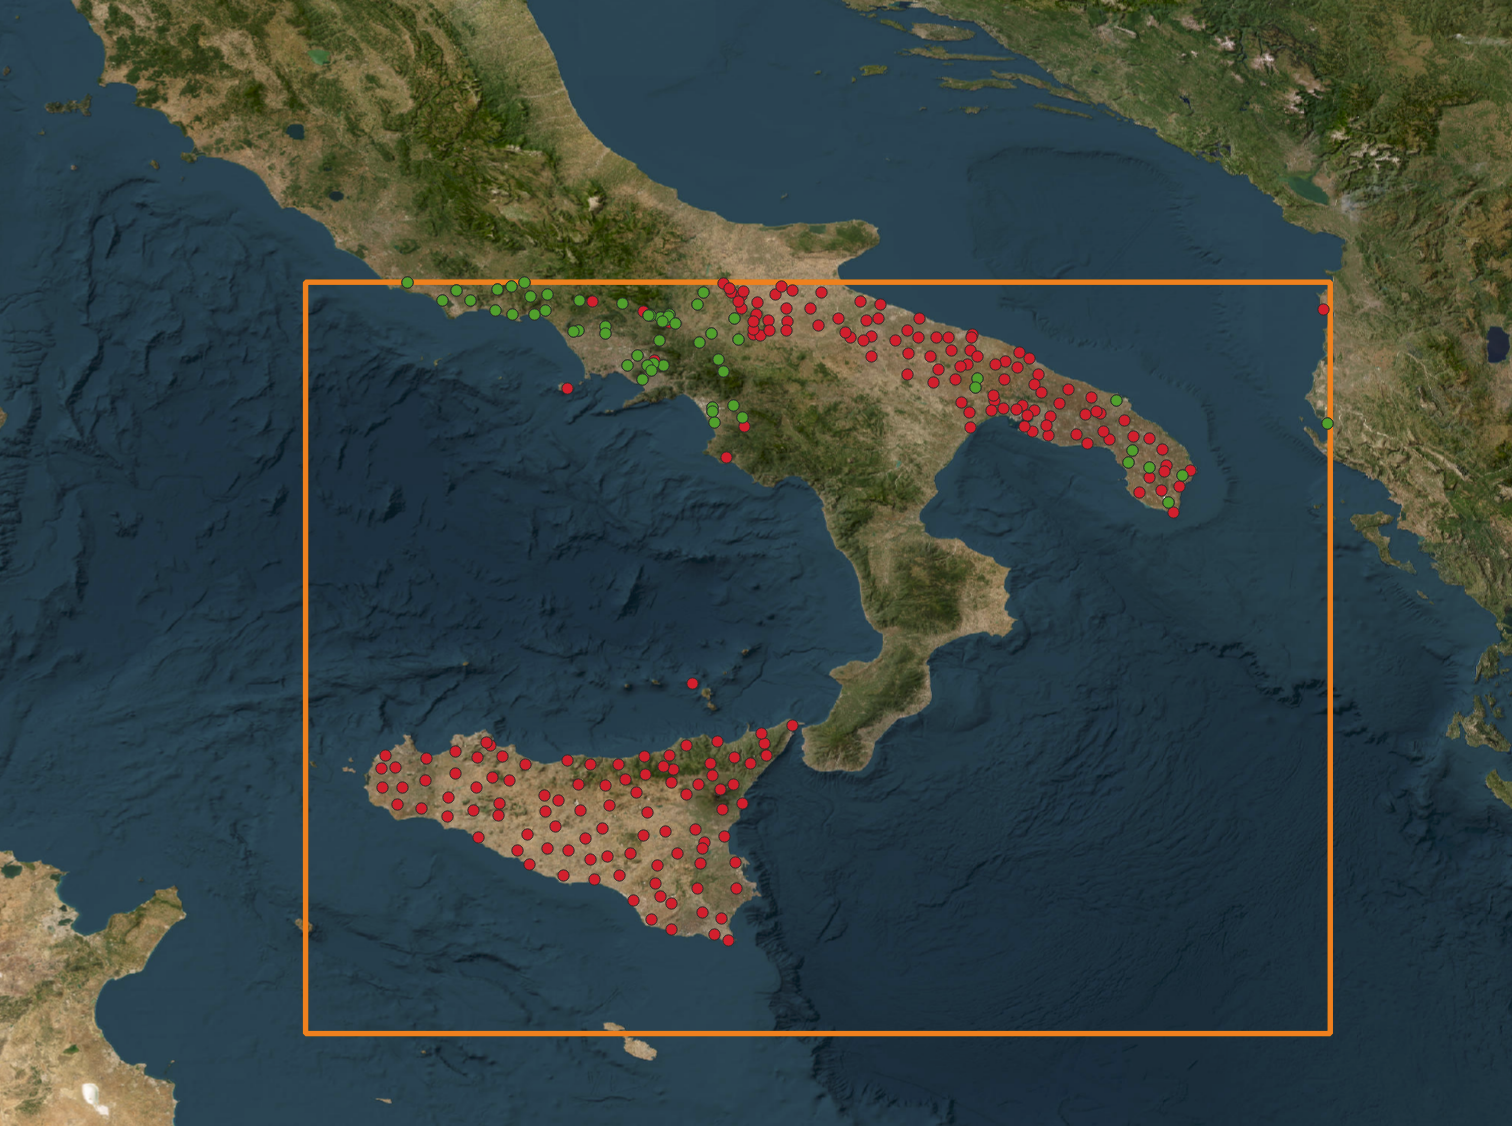

## Diagnostics for all Italy Region

To ensure scientific validity and produce reliable ERA5 diagnostics, we shifted the study area to Central Italy, specifically Toscana, Umbria, Lazio, and the northern part of Campania. 

These regions contain a dense network of high-quality stations with consistent summer data, offering the spatial and environmental diversity (urban–rural, coastal–interior, flat–mountainous) required for a robust analysis of ERA5 summer temperature errors. 

This conclusion was achieved following this part of the Script. 

This part of the Script does the same diagnosis as before but of all Italy region.
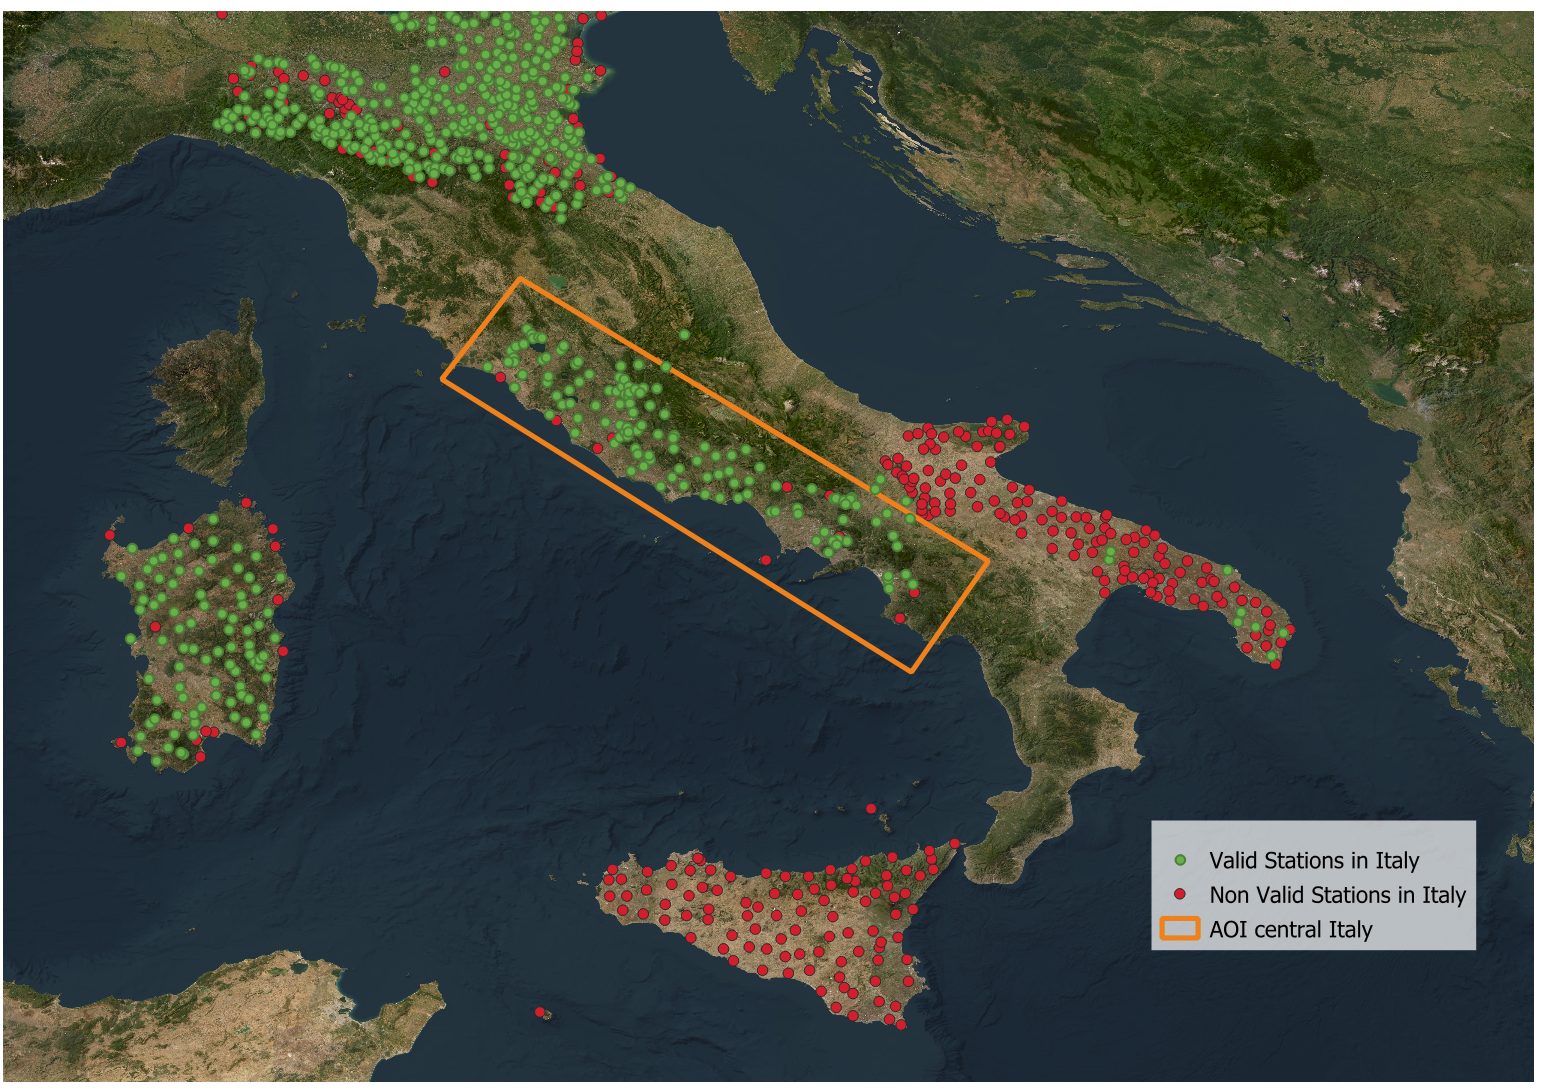
 

In [9]:
from pathlib import Path
from glob import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from shapely.geometry import Point

# ---------- 1. CONFIG – paths and basic settings --------------------

DATA_DIR     = Path(r"D:\Polimi\GenHack 2025\Data")
STATIONS_DIR = DATA_DIR / "ECA_blend_tx"                        # ECA&D TX station files
ERA5_DIR     = DATA_DIR / "derived-era5-land-daily-statistics"  # ERA5-Land daily Tmax

# ECAD station metadata file (stations.txt from ECA&D)
PATH_ST_META = STATIONS_DIR / "stations.txt"

# Output folder for diagnostics and daily tables
OUT_DIR = DATA_DIR / "outputs"
OUT_DIR.mkdir(exist_ok=True)

# Output files (Italy-wide)
OUT_DAILY_TABLE = OUT_DIR / "stations_daily_with_error_italy.parquet"
OUT_DIAG_TABLE  = OUT_DIR / "station_diagnostics_italy.csv"

# Time window and definition of summer (JJA)
YEARS_TARGET   = [2020, 2021, 2022, 2023]
SUMMER_MONTHS  = [6, 7, 8]  # JJA


# ---------- 2. HELPERS (ported from the original notebook) ---------


def dms_to_dd_ecad(s):
    """
    Convert DMS string from ECA&D ('+38:11:00', '-05:30:00', etc.) to decimal degrees.
    """
    if pd.isna(s):
        return np.nan
    s = str(s).strip()
    if not s:
        return np.nan

    # Extract sign and strip leading +/-
    sign = -1 if s[0] == "-" else 1
    if s[0] in "+-":
        s = s[1:]

    parts = s.split(":")
    if len(parts) != 3:
        return np.nan

    d, m, sec = map(float, parts)
    return sign * (d + m / 60.0 + sec / 3600.0)


def load_era5_tmax_celsius():
    """
    Load ERA5-Land daily maximum 2 m temperature (t2m) from the derived
    NetCDF files and return it in °C, together with the names of
    latitude, longitude and time coordinates.
    """
    variable2statistic = {"2m_temperature": "daily_maximum"}
    variable2datavar   = {"2m_temperature": "t2m"}

    variable  = "2m_temperature"
    statistic = variable2statistic[variable]
    datavar   = variable2datavar[variable]

    # Pattern used in the derived ERA5 files
    pattern = str(ERA5_DIR / f"*_{variable}_{statistic}.nc")
    filepaths = sorted(glob(pattern))
    if not filepaths:
        raise FileNotFoundError(f"No ERA5 files found matching {pattern}")

    print(f"\nLoading ERA5 files ({len(filepaths)}):")
    for fp in filepaths:
        print("  ", fp)

    # Combine all years along the coordinates
    ds = xr.open_mfdataset(filepaths, combine="by_coords")

    # Detect coordinate names (latitude / longitude may vary)
    if "latitude" in ds.coords:
        lat_name = "latitude"
    elif "lat" in ds.coords:
        lat_name = "lat"
    else:
        raise KeyError("Could not find latitude coordinate in ERA5 dataset")

    if "longitude" in ds.coords:
        lon_name = "longitude"
    elif "lon" in ds.coords:
        lon_name = "lon"
    else:
        raise KeyError("Could not find longitude coordinate in ERA5 dataset")

    # Time coordinate can be "time" or "valid_time"
    if "time" in ds.coords:
        time_name = "time"
    elif "valid_time" in ds.coords:
        time_name = "valid_time"
    else:
        raise KeyError("Could not find time coordinate in ERA5 dataset")

    da_kelvin = ds[datavar]
    da_celsius = da_kelvin - 273.15  # convert K → °C
    da_celsius.attrs["units"] = "degC"

    return da_celsius, lat_name, lon_name, time_name


def era5_series_for_point(ds_var, lat_name, lon_name, time_name, lon, lat):
    """
    Extract the ERA5 time series at the grid cell closest to (lon, lat).
    Returns a DataFrame with columns: [date, tmax_era5].
    """
    da = ds_var.sel({lat_name: lat, lon_name: lon}, method="nearest")
    df = da.to_dataframe(name="tmax_era5").reset_index()
    df = df.rename(columns={time_name: "date"})
    return df[["date", "tmax_era5"]]


def summer_mask(dates):
    """Return a boolean mask for summer days (JJA)."""
    return dates.dt.month.isin(SUMMER_MONTHS)


# ---------- 3. LOAD ITALIAN STATION METADATA (ECA&D)  ---------------

# Find header line with "STAID" in stations.txt (skip metadata comments)
header_line_idx = None
with open(PATH_ST_META, "r", encoding="latin1") as f:
    for i, line in enumerate(f):
        if line.startswith("STAID"):
            header_line_idx = i
            print("Found ECAD header at line:", i)
            break

if header_line_idx is None:
    raise RuntimeError("Could not find header starting with 'STAID' in stations.txt")

# Read ECAD station metadata from that header line onwards
stations_meta_raw = pd.read_csv(
    PATH_ST_META,
    skiprows=header_line_idx,
    sep=",",
    engine="python",
)
stations_meta_raw.columns = [c.strip() for c in stations_meta_raw.columns]

stations_meta = stations_meta_raw.copy()
stations_meta["STAID"]   = stations_meta["STAID"].astype(int)
stations_meta["STANAME"] = stations_meta["STANAME"].str.strip()
stations_meta["CN"]      = stations_meta["CN"].str.strip()

# Convert latitude/longitude from DMS to decimal degrees
stations_meta["LAT_dd"] = stations_meta["LAT"].apply(dms_to_dd_ecad)
stations_meta["LON_dd"] = stations_meta["LON"].apply(dms_to_dd_ecad)

print("\nStation metadata sample:")
print(stations_meta[["STAID", "STANAME", "CN", "LAT_dd", "LON_dd"]].head())

# Keep only Italian stations (CN == 'IT')
stations_it = stations_meta[stations_meta["CN"] == "IT"].copy()

# Build a GeoDataFrame with Italian station locations
gdf_it = gpd.GeoDataFrame(
    stations_it,
    geometry=[Point(xy) for xy in zip(stations_it["LON_dd"], stations_it["LAT_dd"])],
    crs="EPSG:4326",
)

stations_roi = gdf_it[["STAID", "STANAME", "LAT_dd", "LON_dd", "geometry"]].copy()
stations_roi = stations_roi.rename(
    columns={"STAID": "station_id", "STANAME": "name", "LAT_dd": "lat", "LON_dd": "lon"}
)

print(f"\nTotal ECAD stations (all countries): {len(stations_meta)}")
print(f"Italian stations (CN == 'IT'):        {len(stations_roi)}")

# (Optional) save all Italian stations as GeoPackage for inspection
STATIONS_IT_GPKG = OUT_DIR / "stations_italy_all.gpkg"
stations_roi.to_file(STATIONS_IT_GPKG, driver="GPKG")
print("Saved all Italian stations to:", STATIONS_IT_GPKG)


# ---------- 4. LOAD ERA5 DAILY TMAX (°C) ----------------------------

tmax_era5_c, lat_name, lon_name, time_name = load_era5_tmax_celsius()
print("\nERA5 DataArray:", tmax_era5_c)

# Restrict ERA5 to the target period (2020–2023)
tmax_era5_c = tmax_era5_c.sel(
    {time_name: slice("2020-01-01", "2023-12-31")}
)


# ---------- 5. BUILD DAILY STATION TX TABLE FOR ITALIAN STATIONS ----

all_station_tx = []

for _, row in stations_roi.iterrows():
    sid = int(row["station_id"])
    sta_name = row["name"]

    path = STATIONS_DIR / f"TX_STAID{sid:06d}.txt"
    if not path.exists():
        print(f"WARNING: file missing for station {sid}: {path}")
        continue

    # Read the raw ECAD file for this station
    df_raw = pd.read_csv(
        path,
        skiprows=20,
        skipinitialspace=True,
    )

    # Keep only good-quality records (Q_TX = 0)
    df_good = df_raw[df_raw["Q_TX"] == 0].copy()
    if df_good.empty:
        continue

    # Convert date and temperature units
    df_good["date"] = pd.to_datetime(df_good["DATE"], format="%Y%m%d")
    df_good["tx"]   = df_good["TX"] / 10.0  # 0.1°C → °C
    df_good = df_good[["date", "tx"]]

    # Attach station metadata
    df_good["station_id"] = sid
    df_good["name"]       = sta_name
    df_good["lon"]        = row["lon"]
    df_good["lat"]        = row["lat"]

    # Restrict to the target years
    df_good = df_good[df_good["date"].dt.year.isin(YEARS_TARGET)]

    all_station_tx.append(df_good)

if not all_station_tx:
    raise RuntimeError("No valid station TX data found for Italian stations.")

df_tx = pd.concat(all_station_tx, ignore_index=True)
print("\nStation TX daily table shape (Italy):", df_tx.shape)


# ---------- 6. BUILD DAILY TABLE WITH ERA5 + ERROR ------------------

daily_list = []

for sid, df_s in df_tx.groupby("station_id"):
    # Get station metadata
    row_meta = stations_roi[stations_roi["station_id"] == sid].iloc[0]
    lon = row_meta["lon"]
    lat = row_meta["lat"]
    name = row_meta["name"]

    # Extract ERA5 series at the nearest grid cell
    df_era = era5_series_for_point(
        tmax_era5_c,
        lat_name,
        lon_name,
        time_name,
        lon=lon,
        lat=lat,
    )

    # Merge station TX and ERA5 Tmax on common dates
    df_merge = pd.merge(df_s, df_era, on="date", how="inner")
    if df_merge.empty:
        continue

    # Compute error (ERA5 - station) and keep coordinates
    df_merge["error"] = df_merge["tmax_era5"] - df_merge["tx"]
    df_merge["lon"]   = lon
    df_merge["lat"]   = lat
    df_merge["name"]  = name

    daily_list.append(df_merge)

df_daily = pd.concat(daily_list, ignore_index=True)
df_daily.to_parquet(OUT_DAILY_TABLE, index=False)

print("\nDaily merged table shape (Italy):", df_daily.shape)


# ---------- 7. STATION DIAGNOSTICS ----------------------------------

def station_diag(df):
    """
    Compute coverage and skill metrics for a single station,
    using the merged daily table (TX + ERA5 + error).
    """
    out = {}
    out["station_id"] = df["station_id"].iloc[0]
    out["name"]       = df["name"].iloc[0]
    out["lon"]        = df["lon"].iloc[0]
    out["lat"]        = df["lat"].iloc[0]

    df = df.copy()
    df["is_valid"]  = df["tx"].notna() & df["tmax_era5"].notna()
    df["year"]      = df["date"].dt.year
    df["is_summer"] = summer_mask(df["date"])

    # Overall coverage (all days 2020–2023)
    out["coverage_total"] = df["is_valid"].mean()

    # Number of summers (JJA) with ≥ 80% valid days
    good_summers = 0
    for y in YEARS_TARGET:
        df_y = df[(df["year"] == y) & df["is_summer"]]
        if len(df_y) == 0:
            continue
        cov_y = df_y["is_valid"].mean()
        if cov_y >= 0.8:
            good_summers += 1
    out["good_summers"] = good_summers

    # Skill metrics (all valid days)
    df_valid = df[df["is_valid"]]
    if len(df_valid) > 10:
        err = df_valid["error"]
        out["bias"] = err.mean()
        out["rmse"] = np.sqrt((err**2).mean())
        out["corr"] = df_valid["tx"].corr(df_valid["tmax_era5"])
    else:
        out["bias"] = np.nan
        out["rmse"] = np.nan
        out["corr"] = np.nan

    # Skill metrics restricted to summer (JJA)
    df_su = df_valid[df_valid["is_summer"]]
    if len(df_su) > 10:
        err_s = df_su["error"]
        out["bias_summer"] = err_s.mean()
        out["rmse_summer"] = np.sqrt((err_s**2).mean())
        out["corr_summer"] = df_su["tx"].corr(df_su["tmax_era5"])
    else:
        out["bias_summer"] = np.nan
        out["rmse_summer"] = np.nan
        out["corr_summer"] = np.nan

    # Final quality flag: station considered "valid" if it has
    # at least two good summers (JJA with coverage >= 80%).
    out["is_valid_station"] = (out["good_summers"] >= 2)

    return out


diag_list = []
for sid, df_st in df_daily.groupby("station_id"):
    diag_list.append(station_diag(df_st))

df_diag = pd.DataFrame(diag_list)
df_diag.to_csv(OUT_DIAG_TABLE, index=False)

print("\nDiagnostics head (Italy):")
print(df_diag.head())

# ---------- 8. SAVE VALID STATIONS AS GEOPACKAGE ---------------------

df_valid = df_diag[df_diag["is_valid_station"]].copy()
gdf_valid = gpd.GeoDataFrame(
    df_valid,
    geometry=gpd.points_from_xy(df_valid["lon"], df_valid["lat"]),
    crs="EPSG:4326",
)
VALID_STATIONS_GPKG = OUT_DIR / "valid_stations_italy.gpkg"
gdf_valid.to_file(VALID_STATIONS_GPKG, driver="GPKG")
print("Saved valid Italian stations to:", VALID_STATIONS_GPKG)


Found ECAD header at line: 17

Station metadata sample:
   STAID                STANAME  CN     LAT_dd     LON_dd
0      1                VAEXJOE  SE  56.866667  14.800000
1      2                  FALUN  SE  60.616667  15.616667
2      3               STENSELE  SE  65.066667  17.166389
3      4             LINKOEPING  SE  58.400000  15.533056
4      5  LINKOEPING-MALMSLAETT  SE  58.400000  15.533056

Total ECAD stations (all countries): 8568
Italian stations (CN == 'IT'):        1112
Saved all Italian stations to: D:\Polimi\GenHack 2025\Data\outputs\stations_italy_all.gpkg

Loading ERA5 files (6):
   D:\Polimi\GenHack 2025\Data\derived-era5-land-daily-statistics\2020_2m_temperature_daily_maximum.nc
   D:\Polimi\GenHack 2025\Data\derived-era5-land-daily-statistics\2021_2m_temperature_daily_maximum.nc
   D:\Polimi\GenHack 2025\Data\derived-era5-land-daily-statistics\2022_2m_temperature_daily_maximum.nc
   D:\Polimi\GenHack 2025\Data\derived-era5-land-daily-statistics\2023_2m_temperature

Interpretation of station_diagnostics.csv
Each row corresponds to one ECAD station inside the AOI.
Columns:
- coverage_total → fraction of valid days (2020–2023) with good TX and ERA5.
- good_summers → number of summers (June-July-August 2020–2023) with ≥ 80% valid days.
- bias → mean(ERA5 − station) over all valid days (°C).
- rmse → typical error magnitude over all valid days (°C).
- corr → correlation between daily ERA5 and station TX (all year).
- bias_summer → mean(ERA5 − station) using only June-July-August days (°C).
- rmse_summer → typical error magnitude using only June-July-August days (°C).
- corr_summer → correlation between ERA5 and station TX in JJA.
- is_valid_station → True if the station meets the quality rule (e.g. good_summers ≥ 2), False otherwise.